# WIRELESS SENSOR NETWORK - DATA ANALYZER
#### Notebook not intended for final product

# LIBRARIES

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import IPython.display
from datetime import datetime
from statistics import mean
from matplotlib.dates import DateFormatter
#NP = DF.to_numpy()
#DF = pd.DataFrame(NP)

# DATA SELCTION
Incoming data has two columns: UNIXTIME and GASDATA

In [4]:
# Set Working Directory
user      = 'adria'
subfolder = 'V 1.2.3B'
#file      = '2020-03-04--08EDITED.csv'
#file      = '2020-03-03--00.csv'
file      = 'C-2020-03-04.csv'


os.chdir('C:\\Users\\'+str(user)+'\\Desktop\\Repository\\WirelessSensorNetwork\\Data\\'
         + str(subfolder))
os.getcwd()
data = pd.read_csv(file)
data.head()

,UnixTime,GasData
0,1583294401,409.0
1,1583294402,409.0
2,1583294403,410.0
3,1583294404,410.0
4,1583294405,410.0


# IMPORT DATA
Prime the data for filtering by turning UNIXTIME and GASDATA columns to floats and by adding DATETIME, REALDATA, and INDEX columns

In [5]:
def importData(data):
    #Create columns
    UnixTime = np.array(data['UnixTime'])
    GasData  = np.array(data['GasData'])
    RealData = np.ones((len(UnixTime), 1))
    rawAllDataDF = pd.DataFrame(np.column_stack((UnixTime, GasData, RealData)))
    rawAllDataDF['DateTime'] = pd.to_datetime(rawAllDataDF.iloc[:,0], unit = 's')
    rawAllDataDF.columns     = ['UnixTime', 'GasData', 'RealData', 'DateTime']

    #Drop duplicates and change datatypes
    rawAllDataDF = rawAllDataDF.drop_duplicates(subset='UnixTime', keep='first')
    rawAllDataDF.UnixTime = rawAllDataDF.UnixTime.astype(int)
    rawAllDataDF.RealData = rawAllDataDF.RealData.astype(int)
    
    #Create dataframe
    rawAllDataNP = rawAllDataDF.to_numpy()
    return rawAllDataDF, rawAllDataNP

    
rawAllDataDF, rawAllDataNP = importData(data)
rawAllDataDF.head()

,UnixTime,GasData,RealData,DateTime
0,1583294401,409.0,1,2020-03-04 04:00:01
1,1583294402,409.0,1,2020-03-04 04:00:02
2,1583294403,410.0,1,2020-03-04 04:00:03
3,1583294404,410.0,1,2020-03-04 04:00:04
4,1583294405,410.0,1,2020-03-04 04:00:05


# IMPORT CHECK
Ensure that the datatypes are correct. <br>
UNIXTIME: Int <br>
GASDATA:  Float <br>
REALDATA: Int <br>
INDEX:    Int <br>
DATETIME: Timestamp <br>
Determines extreme values within the data set <br>


In [6]:
def importCheck(rawAllDataNP, rawAllDataDF):
    #Print datatypes
    print('|----------DATA CHECKER ----------|')
    print('UNIXTIME:', rawAllDataNP[0][0], type(rawAllDataNP[0][0]))
    print('GASDATA :', rawAllDataNP[0][1], type(rawAllDataNP[0][1]))
    print('REALDATA:', rawAllDataNP[0][2], type(rawAllDataNP[0][2])) 
    print('DATETIME:', rawAllDataNP[0][3], type(rawAllDataNP[0][3]), "\n")
    #Print extreme values
    print('Data Amt:', len(rawAllDataNP[:]))
    print('Gas  Min:', min(rawAllDataNP[:,1]))
    print('Gas  Max:', max(rawAllDataNP[:,1]))
    print('Unix Min:', min(rawAllDataNP[:,0]))
    print('Unix Min:', max(rawAllDataNP[:,0]))
       
       
importCheck(rawAllDataNP, rawAllDataDF)

|----------DATA CHECKER ----------|
UNIXTIME: 1583294401 <class 'int'>
GASDATA : 409.0 <class 'float'>
REALDATA: 1 <class 'int'>
DATETIME: 2020-03-04 04:00:01 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 

Data Amt: 10800
Gas  Min: 406.0
Gas  Max: 418.0
Unix Min: 1583294401
Unix Min: 1583305200


# FILTER DATA
Determine the indeces containing bad data. <br>
Create new PandasFrame filAllData <br>

In [7]:
def dataFilterWhere(rawAllDataNP):
    #Determine indices
    gasZerosIndices  = np.where( rawAllDataNP[:,1] == 0)
    gasLowIndices    = np.where((rawAllDataNP[:,1] <= 350) & (rawAllDataNP[:,1] > 0))
    gasHighIndices   = np.where( rawAllDataNP[:,1] >= 5000) 
    gasNegIndices    = np.where( rawAllDataNP[:,1] < 0 )
    timeZerosIndices = np.where( rawAllDataNP[:,0] == 0)
    timeLowIndices   = np.where((rawAllDataNP[:,0] <= 1576594500) & (rawAllDataNP[:,0] > 0))
    timeHighIndices  = np.where( rawAllDataNP[:,0] >= 2000000000)                            
    timeNegIndices   = np.where( rawAllDataNP[:,0] < 0)

    fullRemovalIndices = np.concatenate((
        gasZerosIndices, gasLowIndices, gasHighIndices, gasNegIndices,
        timeZerosIndices,timeLowIndices,timeHighIndices,timeNegIndices), axis = None)
    
    #Print removal info
    print('|----------DATA REMOVED----------|')
    print('Gas  Zeros: ', len(gasZerosIndices[0]))
    print('Gas   Lows: ', len(gasLowIndices[0]))
    print('Gas  Highs: ', len(gasHighIndices[0]))
    print('Gas   Negs: ', len(gasNegIndices[0]))
    print('Time Zeros: ', len(timeZerosIndices[0]))
    print('Time  Lows: ', len(timeLowIndices[0]))
    print('Time Highs: ', len(timeHighIndices[0]))
    print('Time  Negs: ', len(timeNegIndices[0]))
    print('Total Remd: ', (len(gasZerosIndices[0]) + len(gasLowIndices[0]) + 
        len(gasHighIndices [0]) + len(gasNegIndices[0]) + len(timeZerosIndices[0]) + 
        len(timeLowIndices[0]) + len(timeHighIndices[0]) + len(timeNegIndices[0])))
    print('Total Remd: ', len(fullRemovalIndices))

    #Create new dataframe
    filAllDataDF = rawAllDataDF[~rawAllDataDF.index.isin(fullRemovalIndices)]
    filAllDataNP = filAllDataDF.to_numpy()
    return filAllDataNP, filAllDataDF, fullRemovalIndices
    
    
filAllDataNP, filAllDataDF, fullRemovalIndices = dataFilterWhere(rawAllDataNP)

|----------DATA REMOVED----------|
Gas  Zeros:  0
Gas   Lows:  0
Gas  Highs:  0
Gas   Negs:  0
Time Zeros:  0
Time  Lows:  0
Time Highs:  0
Time  Negs:  0
Total Remd:  0
Total Remd:  0


# FRAME SELECTION
Allows user to select viewing frame for analysis purposes. <br>
Determines theoretical length of data assuming perfect collection. <br>
Compares theoretical length to real length. <br>

In [8]:
def windowSelect(filAllDataNP, leftFrame, rightFrame):
    #Determine validity of selected frame
    leftFrameIndex   = np.where( filAllDataNP[:,0] == leftFrame)[0]
    rightFrameIndex  = (np.where( filAllDataNP[:,0] == rightFrame))[0]
    if leftFrameIndex.size == 1 and rightFrameIndex.size == 1 :
        
        #Create dataframe of fraAllData   
        fraAllDataDF = filAllDataDF.iloc[leftFrameIndex[0]:rightFrameIndex[0]+1,:]
        fraAllDataNP = fraAllDataDF.to_numpy()

        #Plot selected window frame
        plt.close('all')
        x  = fraAllDataNP[:,3]  
        y  = fraAllDataNP[:,1]
        plt.plot(x, y, "r-", linewidth = 0.5)
        #plt.plot(x, y, "k-")
        plt.grid()

    else:
            print('Invalid selection')
    return fraAllDataNP, fraAllDataDF


,UnixTime,GasData,RealData,DateTime
0,1583294401,409.0,1,2020-03-04 04:00:01
1,1583294402,409.0,1,2020-03-04 04:00:02
2,1583294403,410.0,1,2020-03-04 04:00:03
3,1583294404,410.0,1,2020-03-04 04:00:04
4,1583294405,410.0,1,2020-03-04 04:00:05


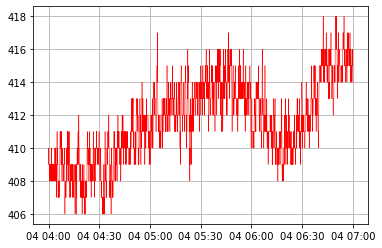

In [9]:
#Select frame limits
#left  = datetime(2020, 3, 4, 8, 0, 10)
#right = datetime(2020, 3, 4, 8, 0, 40)
#leftFrame  = int(datetime.timestamp(left) - 25200.0)
#rightFrame = int(datetime.timestamp(right) - 25200.0)

leftFrame = filAllDataNP[0][0]  #Both indexes are inclusive
rightFrame = filAllDataNP[-1][0] #Both indexes are inclusive

fraAllDataNP, fraAllDataDF = windowSelect(filAllDataNP, leftFrame, rightFrame)
fraAllDataDF.head()

# DETERMINE MISSING DATA
Missing datapoints due to filtering of bad data, node shutdowns, module malfunctions

In [10]:
def missingDataDeterminer(data):
    leftFrameUnix  = data[0][0]
    rightFrameUnix = data[-1][0] 
    spanFrameUnix  = np.arange(leftFrameUnix, rightFrameUnix+1)
    missingData    = np.array([])

    s = set(data[:,0])
    for i in range(0, len(spanFrameUnix)):
        if spanFrameUnix[i] not in s:
            missingData = np.append(missingData, spanFrameUnix[i]) 
    print(len(missingData), "missing points from", [name for name in globals() if globals()   
        [name] is data])
    return missingData


rawMissingData = missingDataDeterminer(rawAllDataNP)
filMissingData = missingDataDeterminer(filAllDataNP)
fraMissingData = missingDataDeterminer(fraAllDataNP)

0 missing points from ['rawAllDataNP']
0 missing points from ['filAllDataNP']
0 missing points from ['fraAllDataNP']


In [11]:
#Clear Space
%reset_selective data, rawAllDataDF, rawAllDataNP
#filAllDataDF = rawAllDataDF[~rawAllDataDF.index.isin(fullRemovalIndices)]

# ESTIMATE DATA
If there is a missing data point in between two real data, make an estimation

In [12]:
def estimateData(missingFra):  
    misGas  = np.array([])
    misReal = np.zeros((len(missingFra)))
    missingFra = missingFra.astype(int) 

    #Perform estimation for every missing index
    for j in missingFra:
        left  = j - 1
        right = j + 1
        #Check that bordering points exist
        if((left in filAllDataNP[:,0])&(right in filAllDataNP[:,0]))==True:
            leftIndex  = np.where(filAllDataNP[:,0] == left)
            rightIndex = np.where(filAllDataNP[:,0] == right)
            leftData   = filAllDataNP[leftIndex[0][0]][1]
            rightData  = filAllDataNP[rightIndex[0][0]][1]
            #Check that bordering points are close in value
            if (abs(leftData - rightData) <= 1) :
                midData = (leftData + rightData) / 2
                misGas  = np.append(misGas, midData)
            else:
                misGas  = np.append(misGas, None)
        else:
            misGas  = np.append(misGas, None)
    print(missingFra)
    print(misGas)
    print(misReal)

    #Combine Estimated Data with Real Data
    estUnix = np.concatenate((fraAllDataNP[:,0], missingFra), axis = 0)    
    estGas  = np.concatenate((fraAllDataNP[:,1], misGas),     axis = 0)
    estReal = np.concatenate((fraAllDataNP[:,2], misReal),    axis = 0)
    df = pd.DataFrame(np.column_stack((estUnix, estGas, estReal)))
    df.columns     = ['UnixTime', 'GasData', 'RealData']

    dfs = df.sort_values(by = ['UnixTime'], inplace = False)
    dfs = dfs.reset_index(drop=True)
    dfs['DateTime'] = pd.to_datetime(dfs.iloc[:,0], unit = 's')
    dfs.GasData = dfs.GasData.astype(float)
    dfs.RealData = dfs.RealData.astype(int)

    #Drop Zeros and Null
    #dfs = dfs[dfs.GasData != 0.0]
    #dfs = dfs[dfs.GasData.notnull()]

    estAllDataDF = dfs
    estAllDataNP = estAllDataDF.to_numpy()
    nanCounter = estAllDataDF.GasData.isna().sum()
    return estAllDataNP, estAllDataDF, nanCounter
estAllDataNP, estAllDataDF, nanCounter = estimateData(fraMissingData)
estAllDataDF.head()

[]
[]
[]


,UnixTime,GasData,RealData,DateTime
0,1583294401,409.0,1,2020-03-04 04:00:01
1,1583294402,409.0,1,2020-03-04 04:00:02
2,1583294403,410.0,1,2020-03-04 04:00:03
3,1583294404,410.0,1,2020-03-04 04:00:04
4,1583294405,410.0,1,2020-03-04 04:00:05


# AVERAGE DATA

In [13]:
def averageData(estAllDataDF, interval):
    avgAllDataDF=estAllDataDF.groupby(pd.Grouper(key='DateTime',freq=interval)).mean().dropna()
    avgAllDataDF = avgAllDataDF.drop(columns=['RealData'])
    avgAllDataDF.reset_index(level=0, inplace=True)
    avgAllDataNP = avgAllDataDF.to_numpy()
    return avgAllDataNP, avgAllDataDF
avgAllDataNP1, avgAllDataDF1 = averageData(estAllDataDF, '10s')
avgAllDataNP2, avgAllDataDF2 = averageData(estAllDataDF, '30s')
avgAllDataNP3, avgAllDataDF3 = averageData(estAllDataDF, '60s')

# FINAL PLOT

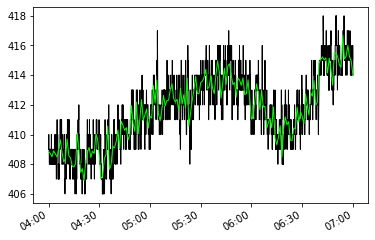

In [14]:
x0 = estAllDataNP[:,3]
y0 = estAllDataNP[:,1]
x1 = avgAllDataNP1[:,0]
y1 = avgAllDataNP1[:,1]
x2 = avgAllDataNP2[:,0]
y2 = avgAllDataNP2[:,1]
x3 = avgAllDataNP3[:,0]
y3 = avgAllDataNP3[:,1]

fig, ax = plt.subplots()
plt.plot_date(x0,y0, 'k', linewidth = 1)
#plt.plot_date(x1,y1, 'r')
#plt.plot_date(x2,y2, 'b')
plt.plot_date(x3,y3, 'lime', linewidth = 1)
formatter = DateFormatter('%H:%M')
#formatter = DateFormatter('%m/%d/%y')
ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate()
plt.show()

# DATA SUMMARY

In [20]:
print('|----------NEW DATA SUMMARY----------|')
print('RawNP: ', len(rawAllDataNP[:,0]), len(rawAllDataNP[:,1]), len(rawAllDataNP[:,2]), len        (rawAllDataNP[:,3]))
print('RawDF: ', len(rawAllDataDF[['UnixTime']]), len(rawAllDataDF[['GasData']]), len               (rawAllDataDF[['DateTime']]), len(rawAllDataDF[['RealData']]))
print('FilNP: ', len(filAllDataNP[:,0]), len(filAllDataNP[:,1]), len(filAllDataNP[:,2]), len        (filAllDataNP[:,3]))
print('FilDF: ', len(filAllDataDF[['UnixTime']]), len(filAllDataDF[['GasData']]), len               (filAllDataDF[['DateTime']]), len(filAllDataDF[['RealData']]))
print('Δ    : ', len(rawAllDataNP[:,0]) - len(filAllDataNP[:,0]), "points were filtered out")
print('')
print('Should Have:', int((filAllDataNP[-1][0] - filAllDataNP[0][0])+1), "points in data")
print('Should Have:', int((fraAllDataNP[-1][0] - fraAllDataNP[0][0])+1), "points in frame")
print('')
print('FraNP: ', len(fraAllDataNP[:,0]), len(fraAllDataNP[:,1]), len(fraAllDataNP[:,2]), len        (fraAllDataNP[:,3]))
print('FraDF: ', len(fraAllDataDF[['UnixTime']]), len(fraAllDataDF[['GasData']]), len               (fraAllDataDF[['DateTime']]), len(fraAllDataDF[['RealData']]))
print('EstNP: ', len(estAllDataNP[:,0]), len(estAllDataNP[:,1]), len(estAllDataNP[:,2]), len        (estAllDataNP[:,3]))
print('EstDF: ', len(estAllDataDF[['UnixTime']]), len(estAllDataDF[['GasData']]), len               (estAllDataDF[['DateTime']]), len(estAllDataDF[['RealData']]))
print('Δ    : ', len(estAllDataDF[['UnixTime']]) - len(fraAllDataDF[['UnixTime']]), 'total were     added in')
print('nan  : ', nanCounter, 'are nan values')
print('Thus : ', ((len(estAllDataDF[['UnixTime']]) - len(fraAllDataDF[['UnixTime']])) -             nanCounter), 'real estimated points added')
print('')

#print('AvgNP: ', len(avgAllDataNP1[:,0]), len(avgAllDataNP1[:,1]), len(avgAllDataNP1[:,2]), len  #   (avgAllDataNP1[:,3]))
#print('AvgDF: ', len(avgAllDataDF1[['UnixTime']]), len(avgAllDataDF1[['GasData']]), len             (avgAllDataDF1[['DateTime']]), len(avgAllDataDF1[['RealData']]))
print('')

|----------NEW DATA SUMMARY----------|
RawNP:  10800 10800 10800 10800
RawDF:  10800 10800 10800 10800
FilNP:  10800 10800 10800 10800
FilDF:  10800 10800 10800 10800
Δ    :  0 points were filtered out

Should Have: 10800 points in data
Should Have: 10800 points in frame

FraNP:  10800 10800 10800 10800
FraDF:  10800 10800 10800 10800
EstNP:  10800 10800 10800 10800
EstDF:  10800 10800 10800 10800
Δ    :  0 total were     added in
nan  :  0 are nan values
Thus :  0 real estimated points added


